In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#paramaters
#change all units to: force = pN, length = nm, time = ms
pars = {}
pars['a00'] = -21*10**-3
pars['a01'] = 0
pars['a10'] = 0
pars['a11'] = -1
pars['gamma0'] = 8.72
pars['gamma1'] = 54.8

pars['kbT'] = 4.1
pars['noise0'] = 2*pars['gamma0']*pars['kbT']
pars['noise1'] = 4.916/(1e-3)

pars['delta_t'] = 0.01

In [3]:
def euler_one_traj(n_time, pars):   
    #initial condition
    x1 = 0
    x2 = 0
    x1_traj = []
    x2_traj = []
    
    #performing 1 traj with n_time number of data points
    for i in range(n_time):
        #generate delta_B
        s1 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        s2 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        #solve for x1, x2
        x1_new = x1 + (pars['a00']/pars['gamma0'])*x1*pars['delta_t'] + \
        (pars['a01']/pars['gamma0'])*x2*pars['delta_t'] + \
        np.sqrt((pars['noise0'])/((pars['gamma0'])**2))*s1
                 
        x2_new = x2 + (pars['a11']/pars['gamma1'])*x2*pars['delta_t'] + \
        (pars['a10']/pars['gamma1'])*x1*pars['delta_t'] + \
        np.sqrt((pars['noise1'])/((pars['gamma0'])**2))*s2
                
        x1 = x1_new
        x2 = x2_new
        
        x1_traj.append(x1)
        x2_traj.append(x2)
    return x1_traj, x2_traj

In [4]:
def calc_stochastic_heat_q1(x1, x2, pars):
    """Calculates stochastic heat per time delta following equation (3)
    Input:
    x1 (list) = x1_trajectory_list
    x2 (list) = x2_trajectory_list
    pars (dictionary) = parameters
    
    Here's an example:
    x1 =       [1,2,3,4,5]
    x1_shift = [5,1,2,3,4]
    Then we can easily calculate operations, e.g. dx1 = x1 - x1_ shift
    Vectorization (technique of implementing array operations without using for loop) is easier.
    
    After which, we discard the first element
    
    Returns:
    stochastic heat as shown in equation (3)"""
    x1_shift = np.roll(x1, shift = 1)   
    x2_shift = np.roll(x2, shift = 1)
    
    first_term = pars['a00']*((x1 + x1_shift)/2)
    second_term = pars['a01']*((x2 + x2_shift)/2)
    dx1 = x1 - x1_shift
    return (first_term[1:] + second_term[1:])*dx1[1:]

def calc_stochastic_heat_q2(x1, x2, pars):
    x1_shift = np.roll(x1, shift = 1)   
    x2_shift = np.roll(x2, shift = 1)    
    
    first_term = pars['a11']*((x2 + x2_shift)/2)
    second_term = pars['a10']*((x1 + x1_shift)/2)
    dx2 = x2 - x2_shift
    return (second_term[1:] + first_term[1:])*dx2[1:]

In [5]:
#function to calculate average q (cumulative_heat) after performing n_realizations
def average_q(max1_time, pars):
    min_time = 0
    n_time = int((max1_time - min_time)/pars['delta_t'] + 1) #n_time = num of evenlx2 spaced samples (ex1. 1001 points)
    time = np.linspace(min_time, max1_time, n_time) #time(ex1. 0 (min time), 0.01, 0.02, ..., 10 (max1 time)) with n_time no. of data points
    
    average_q1_trajectorx2 = 0
    average_q2_trajectorx2 = 0
    for i in tqdm(range(pars['n_realizations'])):
        x1_traj, x2_traj = euler_one_traj(n_time, pars)
        q1_trajectorx2 = calc_stochastic_heat_q1(x1_traj, x2_traj, pars)
        q1_cumulative = np.cumsum(q1_trajectorx2)
        
        q2_trajectorx2 = calc_stochastic_heat_q2(x1_traj, x2_traj, pars)
        q2_cumulative = np.cumsum(q2_trajectorx2)
        
        average_q1_trajectorx2 += q1_cumulative/pars['n_realizations']
        average_q2_trajectorx2 += q2_cumulative/pars['n_realizations']
        
    return average_q1_trajectorx2, average_q2_trajectorx2, time[:-1]

In [6]:
#plot stochastic heat
def stochastic_heat_plotter(q1, q2, y_range, pars):
    mean_q1 = np.mean(q1)
    std_q1 = np.std(q1)
    mean_q2 = np.mean(q2)
    std_q2 = np.std(q2)

    plt.figure(figsize=(10,4))
    plt.plot(time, q1, label = 'q1')
    plt.plot(time, q2, alpha = 0.5, label = 'q2')
    plt.title('q1: Mean: {:.3g} and Std Dev: {:.3g} \n q2: Mean: {:.3g} and Std Dev: {:.3g}'.format(mean_q1, std_q1, mean_q2, std_q2))

    plt.suptitle('T1: {}, T2: {}'.format(pars['T1'], pars['T2']))
    plt.xlabel('time')
    plt.ylabel('stochastic heat')
    
    plt.ylim(y_range)

    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
pars['n_realizations'] = 50
q1_neq, q2_neq, time = average_q(300, pars)

100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


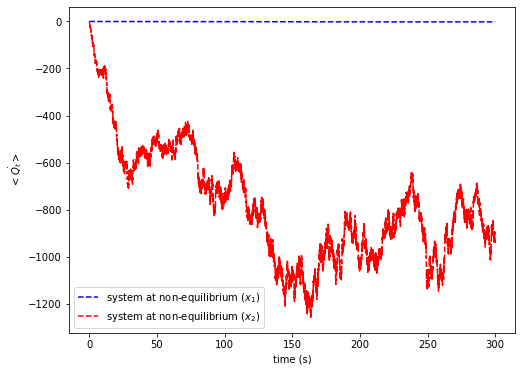

In [8]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(time, q1_neq, color = 'blue', linestyle='dashed', label = 'system at non-equilibrium ($x_1$)')
ax.plot(time, q2_neq, color = 'red',  linestyle='dashed', label= 'system at non-equilibrium ($x_2$)')

plt.xlabel('time (s)')
plt.ylabel('$<\dot{Q_t}>$')
plt.legend()
# plt.savefig('stoch_heat.png', dpi=300)
plt.show()


$$ \delta Q_1 = (a_{00} x_0 + a_{01} x_1) \circ dx_0  $$
$$ \delta Q_2 = (a_{10} x_0 + a_{11} x_1) \circ dx_1  $$


In [9]:
pars['a01'] = 1
pars['a10'] = -1.348

In [10]:
pars['n_realizations'] = 50
q1_neq, q2_neq, time = average_q(300, pars)

100%|██████████| 50/50 [00:56<00:00,  1.14s/it]


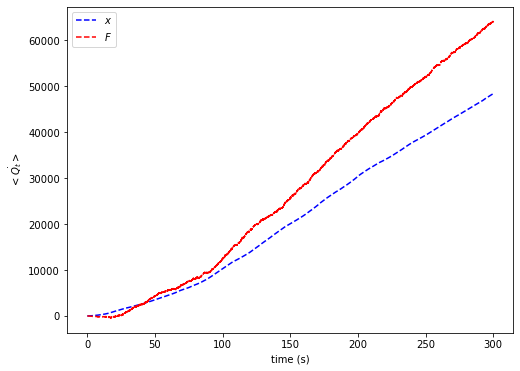

In [11]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(time, q1_neq, color = 'blue', linestyle='dashed', label = '$x$')
ax.plot(time, q2_neq, color = 'red',  linestyle='dashed', label= '$F$')

plt.xlabel('time (s)')
plt.ylabel('$<\dot{Q_t}>$')
plt.legend()
# plt.savefig('stoch_heat.png', dpi=300)
plt.show()

In [18]:
#q1_neq = cumulative stochastic heat for x
#q2_neq = cumulative stochastic heat for F
np.sum(np.abs(q2_neq - q1_neq)*pars['delta_t'])

1974416.4554759725

In [19]:
time[1] - time[0]

0.01

In [24]:
np.sum(np.abs(q2_neq - q1_neq)*0.01)

1974416.4554759725

In [25]:
np.abs(q2_neq - q1_neq)[-1]

15721.314676418158

In [18]:
aa = 1

In [19]:
for i in [0,1,2,3]:
    bb = aa * 3
    print('a', aa)
    print('b', bb)
    aa = aa + bb
    print('new_a', aa)
    
    
    

a 1
b 3
new_a 4
a 4
b 12
new_a 16
a 16
b 48
new_a 64
a 64
b 192
new_a 256
